Uncertainty Methods Comparison


Using device: cpu
Dataset and model loaded!

METHOD 1: STANDARD SOFTMAX (Baseline)
Brier Score: 0.0006
Negative Log-Likelihood: 0.0022
Mean Confidence: 0.9987
Accuracy: 0.9993

METHOD 2: MONTE CARLO DROPOUT (20 samples)
Brier Score: 0.0006
Negative Log-Likelihood: 0.0022
Mean Confidence: 0.9987
Mean Uncertainty (std): 0.0000
Accuracy: 0.9993

METHOD 3: TEMPERATURE SCALING
Optimal temperature: 0.6837
Brier Score: 0.0006
Negative Log-Likelihood: 0.0018
Mean Confidence: 0.9994
Accuracy: 0.9993

METHOD COMPARISON
Standard Softmax          | Brier: 0.0006 | NLL: 0.0022 | Conf: 0.9987 | Acc: 0.9993
MC Dropout                | Brier: 0.0006 | NLL: 0.0022 | Conf: 0.9987 | Acc: 0.9993
Temperature Scaling       | Brier: 0.0006 | NLL: 0.0018 | Conf: 0.9994 | Acc: 0.9993

Results saved to results/uncertainty_methods_comparison.json


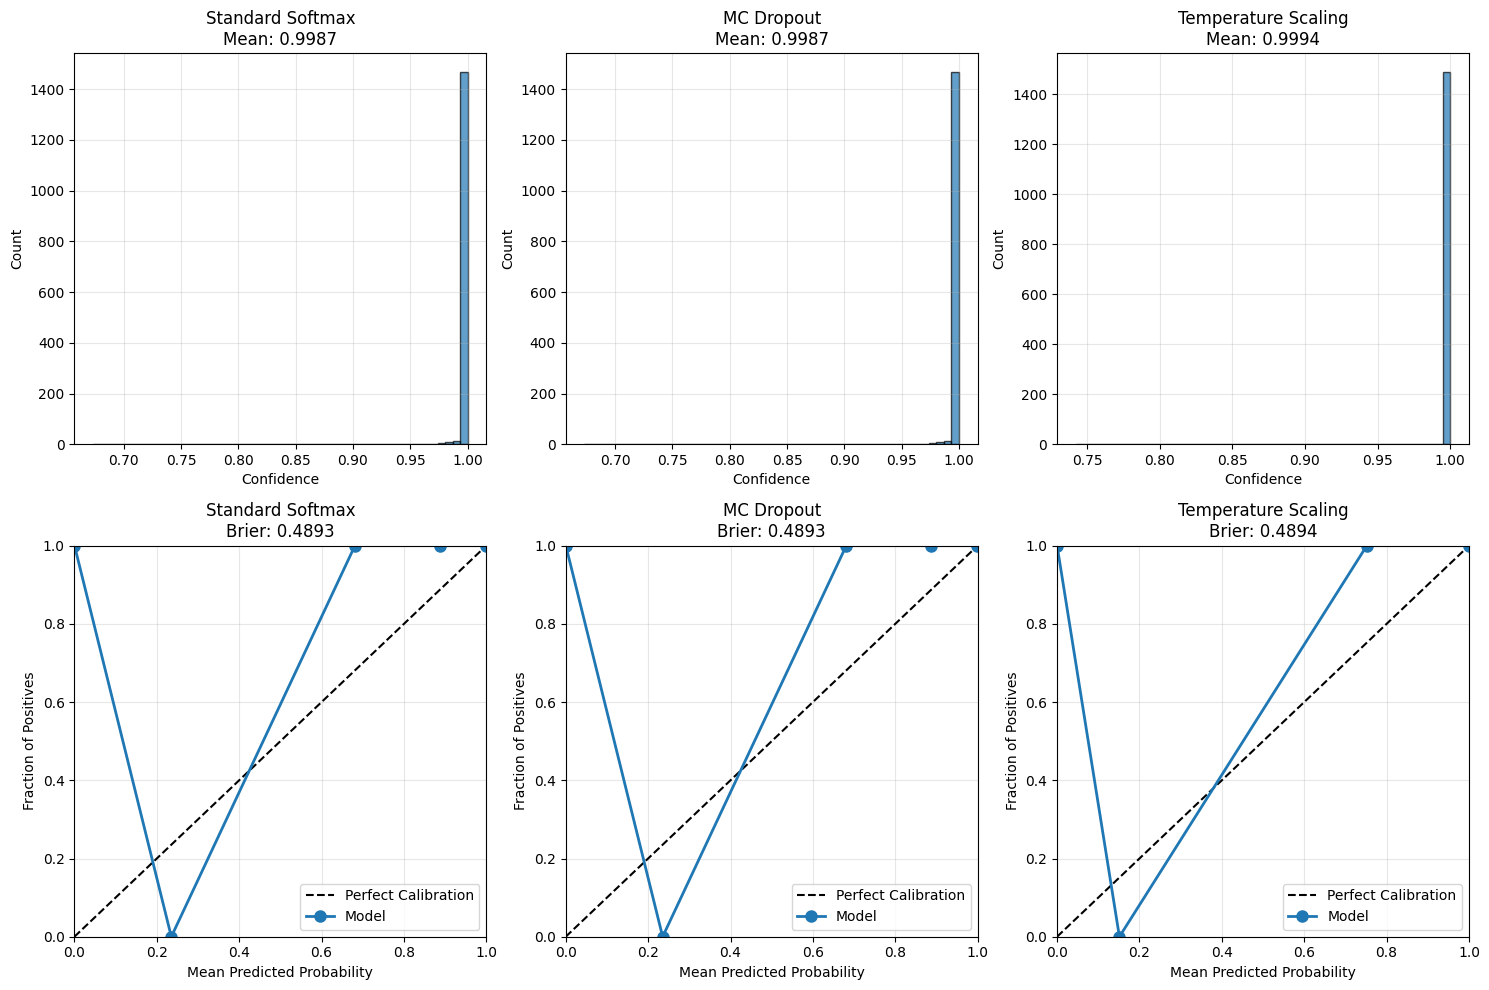


Visualization saved to results/uncertainty_methods_comparison.png


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import os
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# 1. DATASET & MODEL SETUP


class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load baseline model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model = model.to(device)
model.eval()

print("Dataset and model loaded!")


# 2. METHOD 1: STANDARD SOFTMAX (Baseline)


def get_standard_predictions(model, loader, device):
    """Standard deterministic predictions"""
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

print("\n" + "="*70)
print("METHOD 1: STANDARD SOFTMAX (Baseline)")
print("="*70)

std_preds, std_probs, test_labels_arr = get_standard_predictions(model, test_loader, device)
std_confidence = np.max(std_probs, dim=1) if isinstance(std_probs, torch.Tensor) else np.max(std_probs, axis=1)
std_correct = (std_preds == test_labels_arr).astype(int)

std_brier = brier_score_loss(test_labels_arr, std_probs[:, 1])
std_nll = log_loss(test_labels_arr, std_probs)
print(f"Brier Score: {std_brier:.4f}")
print(f"Negative Log-Likelihood: {std_nll:.4f}")
print(f"Mean Confidence: {std_confidence.mean():.4f}")
print(f"Accuracy: {std_correct.mean():.4f}")


# 3. METHOD 2: MONTE CARLO DROPOUT


class MCDropoutModel(nn.Module):
    """ResNet with dropout enabled at test time"""
    def __init__(self, base_model, dropout_rate=0.5):
        super().__init__()
        self.base_model = base_model
        self.dropout_rate = dropout_rate
    
    def forward(self, x):
        # Add dropout to forward pass
        for module in self.base_model.modules():
            if isinstance(module, nn.Dropout):
                module.train()  # Keep dropout active
        
        return self.base_model(x)

def get_mc_dropout_predictions(model, loader, device, n_samples=20):
    """Monte Carlo Dropout: sample predictions multiple times"""
    all_probs_samples = []
    all_labels = []
    
    # Enable dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            batch_samples = []
            
            # Get n_samples forward passes
            for _ in range(n_samples):
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                batch_samples.append(probs.cpu().numpy())
            
            all_probs_samples.append(np.array(batch_samples))
            all_labels.extend(labels.numpy())
    
    # Combine all samples
    all_probs_samples = np.concatenate(all_probs_samples, axis=1)  # (n_samples, n_images, 2)
    all_labels = np.array(all_labels)
    
    # Compute mean and std
    mean_probs = all_probs_samples.mean(axis=0)
    std_probs = all_probs_samples.std(axis=0)
    
    # Predictions from mean
    preds = np.argmax(mean_probs, axis=1)
    
    # Uncertainty: std of tumor class probability
    uncertainty = std_probs[:, 1]
    
    return preds, mean_probs, uncertainty, all_labels

print("\n" + "="*70)
print("METHOD 2: MONTE CARLO DROPOUT (20 samples)")
print("="*70)

mc_preds, mc_probs, mc_uncertainty, mc_labels = get_mc_dropout_predictions(
    model, test_loader, device, n_samples=20
)

mc_confidence = np.max(mc_probs, axis=1)
mc_correct = (mc_preds == mc_labels).astype(int)

mc_brier = brier_score_loss(mc_labels, mc_probs[:, 1])
mc_nll = log_loss(mc_labels, mc_probs)
print(f"Brier Score: {mc_brier:.4f}")
print(f"Negative Log-Likelihood: {mc_nll:.4f}")
print(f"Mean Confidence: {mc_confidence.mean():.4f}")
print(f"Mean Uncertainty (std): {mc_uncertainty.mean():.4f}")
print(f"Accuracy: {mc_correct.mean():.4f}")


# 4. METHOD 3: TEMPERATURE SCALING


def temperature_scale(logits, temperature):
    """Apply temperature scaling to logits"""
    return F.softmax(logits / temperature, dim=1)

def find_optimal_temperature(logits, labels, device):
    """Find optimal temperature using NLL on validation set"""
    temperatures = np.linspace(0.5, 5.0, 50)
    best_temp = 1.0
    best_nll = float('inf')
    
    for temp in temperatures:
        probs = temperature_scale(torch.tensor(logits), temp)
        nll = log_loss(labels, probs.numpy())
        if nll < best_nll:
            best_nll = nll
            best_temp = temp
    
    return best_temp

def get_temperature_scaled_predictions(model, loader, device, temperature=1.0):
    """Get predictions with temperature scaling"""
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            all_logits.append(logits.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.array(all_labels)
    
    # Apply temperature scaling
    logits_tensor = torch.tensor(all_logits, dtype=torch.float32)
    scaled_probs = temperature_scale(logits_tensor, temperature).numpy()
    
    preds = np.argmax(scaled_probs, axis=1)
    
    return preds, scaled_probs, all_labels

print("\n" + "="*70)
print("METHOD 3: TEMPERATURE SCALING")
print("="*70)

# Get logits first (need separate pass)
with torch.no_grad():
    all_logits = []
    all_labels_temp = []
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        all_logits.append(logits.cpu().numpy())
        all_labels_temp.extend(labels.numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels_temp = np.array(all_labels_temp)

# Find optimal temperature (using standard softmax probs as reference)
optimal_temp = find_optimal_temperature(all_logits, all_labels_temp, device)
print(f"Optimal temperature: {optimal_temp:.4f}")

temp_preds, temp_probs, temp_labels = get_temperature_scaled_predictions(
    model, test_loader, device, temperature=optimal_temp
)

temp_confidence = np.max(temp_probs, axis=1)
temp_correct = (temp_preds == temp_labels).astype(int)

temp_brier = brier_score_loss(temp_labels, temp_probs[:, 1])
temp_nll = log_loss(temp_labels, temp_probs)
print(f"Brier Score: {temp_brier:.4f}")
print(f"Negative Log-Likelihood: {temp_nll:.4f}")
print(f"Mean Confidence: {temp_confidence.mean():.4f}")
print(f"Accuracy: {temp_correct.mean():.4f}")


# 5. COMPARISON & VISUALIZATION


print("\n" + "="*70)
print("METHOD COMPARISON")
print("="*70)

comparison_df = {
    'Method': ['Standard Softmax', 'MC Dropout', 'Temperature Scaling'],
    'Brier Score': [std_brier, mc_brier, temp_brier],
    'NLL': [std_nll, mc_nll, temp_nll],
    'Mean Confidence': [std_confidence.mean(), mc_confidence.mean(), temp_confidence.mean()],
    'Accuracy': [std_correct.mean(), mc_correct.mean(), temp_correct.mean()]
}

for method, brier, nll, conf, acc in zip(
    comparison_df['Method'], comparison_df['Brier Score'], 
    comparison_df['NLL'], comparison_df['Mean Confidence'], 
    comparison_df['Accuracy']
):
    print(f"{method:25s} | Brier: {brier:.4f} | NLL: {nll:.4f} | Conf: {conf:.4f} | Acc: {acc:.4f}")

# Save comparison results
results = {
    'standard_softmax': {
        'brier': float(std_brier),
        'nll': float(std_nll),
        'confidence': std_confidence.tolist(),
        'correct': std_correct.tolist()
    },
    'mc_dropout': {
        'brier': float(mc_brier),
        'nll': float(mc_nll),
        'confidence': mc_confidence.tolist(),
        'uncertainty': mc_uncertainty.tolist(),
        'correct': mc_correct.tolist()
    },
    'temperature_scaling': {
        'temperature': float(optimal_temp),
        'brier': float(temp_brier),
        'nll': float(temp_nll),
        'confidence': temp_confidence.tolist(),
        'correct': temp_correct.tolist()
    }
}

with open('results/uncertainty_methods_comparison.json', 'w') as f:
    json.dump(results, f)

print("\nResults saved to results/uncertainty_methods_comparison.json")


# 6. VISUALIZATION


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Confidence distributions
for idx, (conf, label) in enumerate([
    (std_confidence, 'Standard Softmax'),
    (mc_confidence, 'MC Dropout'),
    (temp_confidence, 'Temperature Scaling')
]):
    axes[0, idx].hist(conf, bins=50, alpha=0.7, edgecolor='black')
    axes[0, idx].set_xlabel('Confidence')
    axes[0, idx].set_ylabel('Count')
    axes[0, idx].set_title(f'{label}\nMean: {conf.mean():.4f}')
    axes[0, idx].grid(alpha=0.3)

# Row 2: Calibration curves
methods_data = [
    (std_correct, std_probs[:, 1], 'Standard Softmax'),
    (mc_correct, mc_probs[:, 1], 'MC Dropout'),
    (temp_correct, temp_probs[:, 1], 'Temperature Scaling')
]

for idx, (correct, probs, label) in enumerate(methods_data):
    prob_true, prob_pred = calibration_curve(correct, probs, n_bins=10, strategy='uniform')
    
    axes[1, idx].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[1, idx].plot(prob_pred, prob_true, 'o-', label='Model', linewidth=2, markersize=8)
    axes[1, idx].set_xlabel('Mean Predicted Probability')
    axes[1, idx].set_ylabel('Fraction of Positives')
    axes[1, idx].set_title(f'{label}\nBrier: {brier_score_loss(correct, probs):.4f}')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)
    axes[1, idx].set_xlim([0, 1])
    axes[1, idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('results/uncertainty_methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to results/uncertainty_methods_comparison.png")
